# Prepare Data

## Set up Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_code import *
from sklearn.preprocessing import StandardScaler
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load dataset csv
The dataset here basically has the filenames of each recording, and the tf.Dataset object will load the recording itself during the training

In [2]:
full_df = pd.read_csv("full_dataset.csv")
full_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A2112.mat,0,0,0,0,CP
1,data/cpsc/A4563.mat,0,0,0,0,CP
2,data/cpsc/A0705.mat,0,0,0,0,CP
3,data/cpsc/A6374.mat,0,0,0,0,CP
4,data/cpsc/A6412.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS38132.mat,0,0,0,0,NI
85739,data/ningbo/JS37201.mat,0,0,0,0,NI
85740,data/ningbo/JS28321.mat,0,0,0,0,NI
85741,data/ningbo/JS41397.mat,0,0,0,0,NI


In [3]:
test_df = full_df[full_df['DB'] == 'CH']
test_df

,Recording,Afib,Afl,MI,SVT,DB
40591,data/chapman/JS01972.mat,0,0,0,0,CH
40592,data/chapman/JS03803.mat,0,0,0,0,CH
40593,data/chapman/JS08956.mat,0,0,0,0,CH
40594,data/chapman/JS09490.mat,0,0,0,0,CH
40595,data/chapman/JS08942.mat,1,0,0,0,CH
...,...,...,...,...,...,...
50833,data/chapman/JS08783.mat,0,0,0,0,CH
50834,data/chapman/JS06976.mat,1,0,0,0,CH
50835,data/chapman/JS08797.mat,0,0,0,0,CH
50836,data/chapman/JS09489.mat,0,0,0,0,CH


In [4]:
train_val_df = full_df[full_df['DB'] != 'CH']
train_val_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A2112.mat,0,0,0,0,CP
1,data/cpsc/A4563.mat,0,0,0,0,CP
2,data/cpsc/A0705.mat,0,0,0,0,CP
3,data/cpsc/A6374.mat,0,0,0,0,CP
4,data/cpsc/A6412.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS38132.mat,0,0,0,0,NI
85739,data/ningbo/JS37201.mat,0,0,0,0,NI
85740,data/ningbo/JS28321.mat,0,0,0,0,NI
85741,data/ningbo/JS41397.mat,0,0,0,0,NI


In [5]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [6]:
# Ensure that the % of Afl is the same as the 20% train test split
print("% of Afl in test: {}".format(val_df['Afl'].sum()/train_val_df['Afl'].sum()))

% of Afl in test: 0.20323354806113428


## Visualize Data Augmentations
We increase the dataset with 3 augmentations:
1. Adding low freq sine wave as baseline wander
2. Adding 50Hz power line noise
3. Adding random gaussian noise

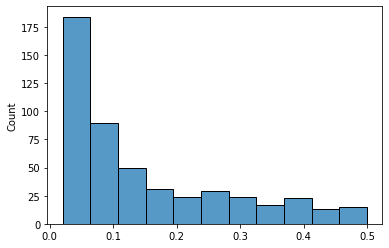

In [7]:
# Use loguniform so as to concentrate the randomness in the lower spectrum

from scipy.stats import loguniform

arr = []
for i in range(500):
    arr.append(loguniform.rvs(0.02, 0.5, size=None))
    
sns.histplot(data=arr)
plt.show()

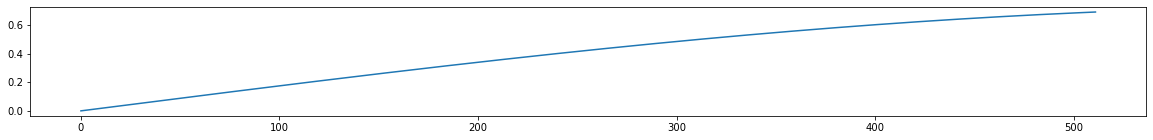

In [8]:
# Baseline Wander

def get_bw(qrs_amp):
    amp = np.random.rand() * 0.15 * qrs_amp      # Amplitude
    f = loguniform.rvs(0.02, 0.5, size=None)     # Frequency
    fs = 100                                     # Sample Rate
    t = 5.12

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)

y = get_bw(6)

plt.figure(figsize=(20,2))
plt.plot(list(range(len(y))), y)

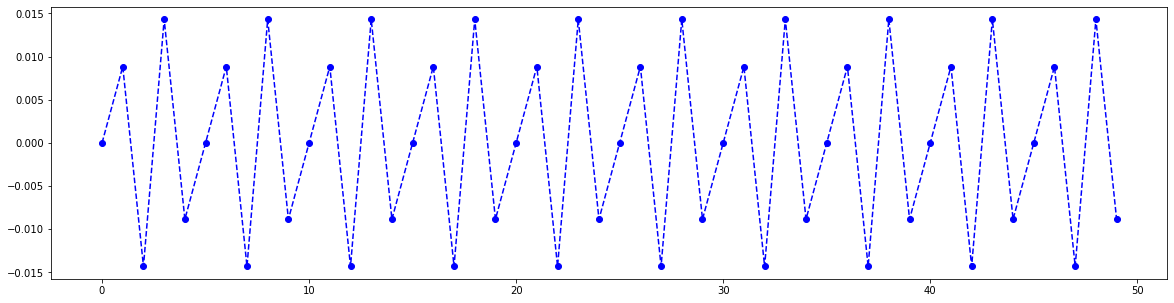

In [9]:
# Power Line

def get_pli(qrs_amp):
    amp = qrs_amp * 0.025 * np.random.rand()    # Amplitude
    f = 40     # Frequency
    fs = 100     # Sample Rate
    t = 5.12

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)
    
y = get_pli(6.5)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(y[:50]))), y[:50], '--bo')

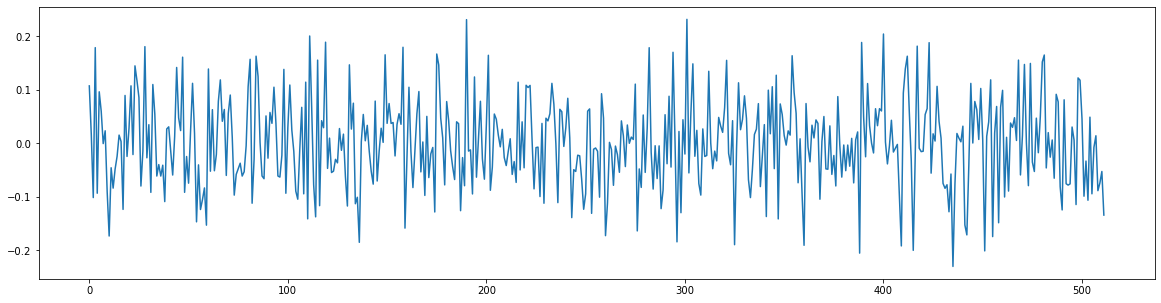

In [10]:
# Gaussian Noise

def get_gauss():
    gauss = np.random.normal(0, 0.08, (512,))
    
    return gauss

gauss = get_gauss()

plt.figure(figsize=(20,5))
plt.plot(list(range(len(gauss))), gauss)

## Preprocess Signal

In [11]:
scaler = StandardScaler()
# filename = 'data/ptbxl/HR08056.mat' # normal
filename = 'data/chapman/JS06976.mat' # Afl

recording = load_recording(filename)
recording = recording.astype(np.float32).T
recording = recording[0:5000:5] # resample to 100Hz
recording = recording[:512] # take only first 512 points (or 5.12 seconds)
recording = scaler.fit_transform(recording) # Normalize

lead = recording.T[0]
print(lead.shape)

(512,)


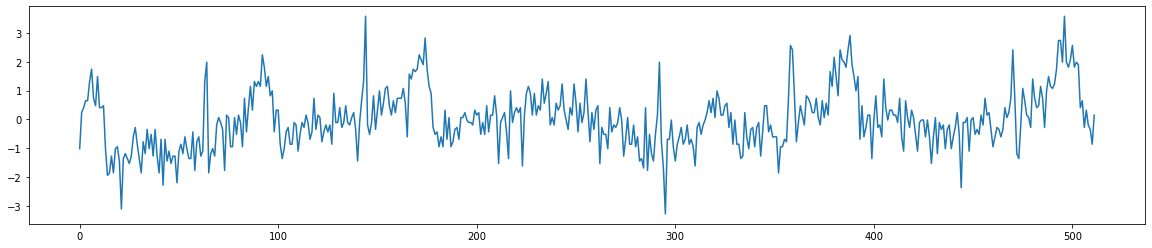

In [12]:
# visualisation of leads without augmentation

plt.figure(figsize=(20,4))
plt.plot(list(range(len(lead))), lead)

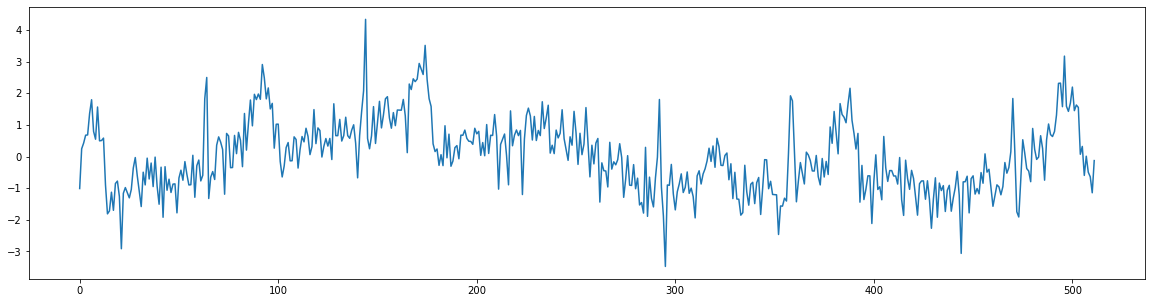

In [13]:
# visualisation of lead with baseline wander
lead_1 = lead + get_bw(6)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(lead_1))), lead_1)

In [14]:
def augment_leads(lead, aug_no):
    qrs_amp = max(lead.max(), abs(lead.min()))
        
    if aug_no == 2:
        lead = lead + get_bw(qrs_amp)
    elif aug_no == 3:
        lead = lead + get_pli(qrs_amp)
    elif aug_no == 4:
        lead = lead + get_gauss()
    
    return lead

In [15]:
start = time.time()

lead = augment_leads(lead, 4)

end = time.time()
end-start

0.0014498233795166016

# Model for Afl

## Afl Data

In [16]:
afl_train = train_df[['Recording', 'Afl']]
afl_train

,Recording,Afl
38263,data/ptbxl/HR02774.mat,0
81071,data/ningbo/JS36455.mat,0
10602,data/georgia/E07977.mat,0
3428,data/cpsc/A3072.mat,0
60796,data/ningbo/JS12159.mat,0
...,...,...
37194,data/ptbxl/HR02566.mat,0
6265,data/cpsc2/Q2287.mat,0
65133,data/ningbo/JS21581.mat,0
860,data/cpsc/A2909.mat,0


In [17]:
afl_train_F = afl_train[afl_train['Afl'] == 0]
afl_train_F

,Recording,Afl
38263,data/ptbxl/HR02774.mat,0
81071,data/ningbo/JS36455.mat,0
10602,data/georgia/E07977.mat,0
3428,data/cpsc/A3072.mat,0
60796,data/ningbo/JS12159.mat,0
...,...,...
37194,data/ptbxl/HR02566.mat,0
6265,data/cpsc2/Q2287.mat,0
65133,data/ningbo/JS21581.mat,0
860,data/cpsc/A2909.mat,0


In [18]:
afl_train_T = afl_train[afl_train['Afl'] == 1]
afl_train_T

,Recording,Afl
65946,data/ningbo/JS18512.mat,1
80734,data/ningbo/JS19298.mat,1
73737,data/ningbo/JS12624.mat,1
75517,data/ningbo/JS15411.mat,1
80597,data/ningbo/JS13010.mat,1
...,...,...
65838,data/ningbo/JS16517.mat,1
78395,data/ningbo/JS17261.mat,1
53248,data/ningbo/JS13352.mat,1
69397,data/ningbo/JS18454.mat,1


In [19]:
# increase positive afl examples to reduce class imbalance
for i in range(6):
    afl_train_T = pd.concat([afl_train_T, afl_train[afl_train['Afl'] == 1]], ignore_index=True)
afl_train_T

,Recording,Afl
0,data/ningbo/JS18512.mat,1
1,data/ningbo/JS19298.mat,1
2,data/ningbo/JS12624.mat,1
3,data/ningbo/JS15411.mat,1
4,data/ningbo/JS13010.mat,1
...,...,...
44151,data/ningbo/JS16517.mat,1
44152,data/ningbo/JS17261.mat,1
44153,data/ningbo/JS13352.mat,1
44154,data/ningbo/JS18454.mat,1


In [20]:
scaler = StandardScaler()
# filename = 'data/ptbxl/HR08056.mat' # normal
filename = 'data/georgia/E05729.mat' # Afl

recording = load_recording(filename)
recording = recording.astype(np.float32).T
recording = recording[0:5000:5] # resample to 100Hz
recording = recording[:512] # take only first 512 points (or 5.12 seconds)
recording = scaler.fit_transform(recording) # Normalize

lead = recording.T[0]
print(lead.shape)

(512,)


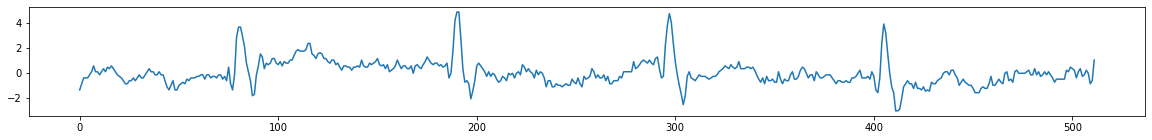

In [21]:
plt.figure(figsize=(20,2))
plt.plot(list(range(len(lead))), lead)

In [22]:
afl_train = pd.concat([afl_train_T, afl_train_F], ignore_index=True)
afl_train = afl_train.sample(frac=1).reset_index(drop=True)
afl_train

,Recording,Afl
0,data/cpsc/A2601.mat,0
1,data/ningbo/JS15751.mat,1
2,data/ptbxl/HR11815.mat,0
3,data/cpsc/A4047.mat,0
4,data/ningbo/JS18372.mat,1
...,...,...
98239,data/ningbo/JS15605.mat,1
98240,data/ningbo/JS13836.mat,1
98241,data/ningbo/JS14406.mat,1
98242,data/ningbo/JS13503.mat,1


In [23]:
x_train = np.array(afl_train['Recording'])
x_train

array(['data/cpsc/A2601.mat', 'data/ningbo/JS15751.mat',
       'data/ptbxl/HR11815.mat', ..., 'data/ningbo/JS14406.mat',
       'data/ningbo/JS13503.mat', 'data/ptbxl/HR06671.mat'], dtype=object)

In [24]:
y_train = np.array(afl_train[['Afl']])
y_train.shape

(98244, 1)

In [25]:
x_val = np.array(val_df['Recording'])
x_val

array(['data/ptbxl/HR06985.mat', 'data/ningbo/JS16627.mat',
       'data/ningbo/JS34146.mat', ..., 'data/ptbxl/HR20457.mat',
       'data/ningbo/JS17853.mat', 'data/ptbxl/HR12950.mat'], dtype=object)

In [26]:
y_val = np.array(val_df[['Afl']])
y_val.shape

(15100, 1)

## Dataset Prep

In [27]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [28]:
scaler = StandardScaler()

In [29]:
def get_ecg(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:5] # resample to 100Hz
        recording = recording[:512] # take only first 512 points (or 5.12 seconds)
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T[0]
        
        # Random number from 1 to 6. 
        # 2, 3, 4 will have augmentations, 1, 5, 6, will be original
        lead = augment_leads(lead, np.random.randint(1, 7))
        
        return lead.astype(np.float32).T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (512, 1))

    return recording, label

In [30]:
def get_val(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:5] # resample to 100Hz
        recording = recording[:512] # take only first 512 points (or 5.12 seconds)
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T[0]
        
        return lead.T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (512, 1))

    return recording, label

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_ecg)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(64, drop_remainder=True)

In [32]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(64, drop_remainder=True)

In [33]:
train_dataset, val_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(64, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 1), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(64, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 1), dtype=tf.int64, name=None))>)

In [34]:
start = time.time()

for batch, (x, y) in enumerate(train_dataset):
    if batch > 0:
        break
print("batch: ", batch)
print("Data shape: ", x.shape, y.shape)

stop = time.time()
print("time elapsed: {}".format(stop - start))

batch:  1
Data shape:  (64, 512, 1) (64, 1)
time elapsed: 45.44073820114136


In [35]:
ecg = x[30].numpy()
ecg = ecg.T
ecg.shape

(1, 512)

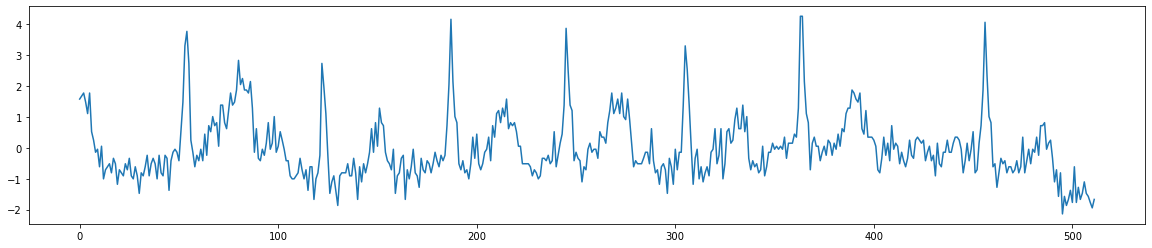

In [36]:
plt.figure(figsize=(20,4))
plt.plot(list(range(len(ecg[0]))), ecg[0])

In [37]:
y.numpy()

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]])

## Single Res Block

In [38]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization
from tensorflow.keras.layers import ReLU, Add, MaxPool1D, GlobalAvgPool1D, Dropout, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [48]:
def Conv_Relu(x, filters, kernel_size, strides):
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.002))(x)
    x = ReLU()(x)
    return x

In [49]:
Inp = Input(shape=(512, 1),name="Inp")
 
x = Conv_Relu(Inp, filters=8, kernel_size=5, strides=1)
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = Conv_Relu(x, filters=16, kernel_size=3, strides=1)
x = Conv_Relu(x, filters=32, kernel_size=3, strides=1) 
 
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
 
model = Model(Inp, output, name='simple-res')

In [50]:
model.summary()

Model: "simple-res"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inp (InputLayer)             [(None, 512, 1)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 8)            48        
_________________________________________________________________
re_lu_3 (ReLU)               (None, 512, 8)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 8)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 16)           400       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 256, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 256, 32)           1

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2) # label smoothing to prevent large weights

model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

In [52]:
filepath="afl_checkpoints/weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
model.fit(train_dataset,
          steps_per_epoch = int(98598/64),
          epochs=25,
          validation_data = val_dataset,
          validation_steps = int(15100/64),
          callbacks=[checkpoint_cb]
          )

In [53]:
model.load_weights("afl_checkpoints/weights-13-0.47.hdf5")
model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

In [39]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [66]:
for layer in model.layers:
    print("")
    print("")
    print("New Layer :))")
    print("")
    print("Config:")
    print("")
    print(layer.get_config())
    print("")
    print("")
    print("Weights:")
    print("")
    if layer.get_weights() == []:
        print("No Weights")
    else:
        print(layer.get_weights()[0].shape)
        print(layer.get_weights()[0])
        print("")
        print("Biases:")
        print("")
        print(layer.get_weights()[1])



New Layer :))

Config:

{'batch_input_shape': (None, 512, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'Inp'}


Weights:

No Weights


New Layer :))

Config:

{'name': 'conv1d_3', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': (5,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0020000000949949026}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


Weights:

(5, 1, 8)
[[[-0.12238387  0.0765212   0.3069601   0.04577918 -0.0182233
   -0.3221132   0.4463714  -0.27931526]]

 [[-0.00352143 -0.03749179  0.16927952 -0.0806561  -0.15590847
    0.34616825  0.25235933 -0.17346378]]

 [[ 0.1391521

In [105]:
biases = model.layers[10].get_weights()[1]
biases

array([0.12140758, 0.07390667, 0.07635945, 0.08393558, 0.10787857,
       0.09080049, 0.09787963, 0.13078402, 0.10578793, 0.10421177,
       0.11962011, 0.0849428 , 0.08811368, 0.07576843, 0.11725749,
       0.13227935], dtype=float32)

In [232]:
string = ''

In [233]:
# conv1d

string = string + 'conv1d, First Conv Layer ==================================== '
string = string + '\n\n'
string = string + 'Weights:'
string = string + '\n\n'

weights = model.layers[1].get_weights()[0].reshape(1, 5, 8)[0].T
biases = model.layers[1].get_weights()[1].reshape(8, 1)
weights = np.concatenate([biases, weights], axis=1)

for row in weights:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [234]:
# conv1d_1

string = string + 'conv1d_1, Second Conv Layer ==================================== '
string = string + '\n\n'
string = string + 'Weights:'
string = string + '\n\n'

filters = model.layers[4].get_weights()[0]
filters = np.swapaxes(filters, 0, 1)
filters = np.swapaxes(filters, 1, 2)
biases = model.layers[4].get_weights()[1].reshape(16, 1)

count = 0

for filt in filters:
    string = string + "Filter " + str(count) + '\n\n'
    count += 1
    filt = np.concatenate([biases, filt], axis=1)
    for kernel in filt:
        for element in kernel:
            string = string + str(round(element * 256)) + '\t'
        string = string + '\n'
    string = string + '\n\n'

string = string + '\n\n\n\n'

In [235]:
# conv1d_2

string = string + 'conv1d_2, Third Conv Layer ==================================== '
string = string + '\n\n'
string = string + 'Weights:'
string = string + '\n\n'

filters = model.layers[6].get_weights()[0]
filters = np.swapaxes(filters, 0, 1)
filters = np.swapaxes(filters, 1, 2)
biases = model.layers[6].get_weights()[1].reshape(32, 1)

count = 0

for filt in filters:
    string = string + "Filter " + str(count) + '\n\n'
    count += 1
    filt = np.concatenate([biases, filt], axis=1)
    for kernel in filt:
        for element in kernel:
            string = string + str(round(element * 256)) + '\t'
        string = string + '\n'
    string = string + '\n\n'

string = string + '\n\n\n\n'

In [236]:
# dense

string = string + 'dense, First Dense Layer ==================================== '
string = string + '\n\n'
string = string + 'Weights:'
string = string + '\n\n'

weights = model.layers[10].get_weights()[0]
weights = np.swapaxes(weights, 0, 1)
biases = model.layers[10].get_weights()[1].reshape(16, 1)
weights = np.concatenate([biases, weights], axis=1)

for node in weights:
    for element in node:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [237]:
# dense_1

string = string + 'dense_1, Second Dense Layer ==================================== '
string = string + '\n\n'
string = string + 'Weights:'
string = string + '\n\n'

weights = model.layers[12].get_weights()[0].reshape(16)
biases = model.layers[12].get_weights()[1]
weights = np.concatenate([biases, weights])

for element in weights:
    string = string + str(round(element * 256)) + '\t'

In [238]:
with open('cnn_weights.txt', 'w') as f:
    f.write(string)

## Results

Precision = Out of all cases that are PREDICTED as positive, how many of them are ACTUALLY positive

Recall = Out of all cases that are ACTUALLY positive, how many of them are PREDICTED as positive

True Positive Rate = if a patient actually has Afl, how many percent of the time will the algorithm identify that he has Afl

False Positive Rate = if a patient actually does NOT have Afl, how many percent of the time will the algorithm say that he has Afl

### Train Results

In [45]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

In [46]:
y_train = np.array(afl_train[['Afl']])
y_train.shape

(98244, 1)

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_val)
train_dataset = train_dataset.batch(64, drop_remainder=False)

In [48]:
y_pred = model.predict(train_dataset)
y_pred

array([[0.6753967 ],
       [0.28067917],
       [0.08791265],
       ...,
       [0.65864635],
       [0.78594095],
       [0.63229835]], dtype=float32)

In [49]:
y_pred.shape

(98244, 1)

In [50]:
afl_true = y_train.T[0]
afl_pred = y_pred.T[0]

afl_pred = np.around(afl_pred).astype(np.int)

In [51]:
cf_m = confusion_matrix(afl_true, afl_pred)
cf_m

array([[47308,  6780],
       [ 4403, 39753]])

In [52]:
afl_true.sum()

44156

True Postive Rate: 0.900285351934052
False Postive Rate: 0.12535127939653898


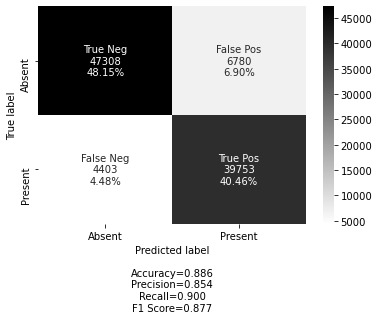

In [53]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

### Val Results

In [54]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.batch(64, drop_remainder=False)

In [55]:
y_pred = model.predict(val_dataset)
y_pred

array([[0.15842924],
       [0.77012646],
       [0.10499611],
       ...,
       [0.0827693 ],
       [0.4612089 ],
       [0.7112655 ]], dtype=float32)

In [56]:
y_pred.shape

(15100, 1)

In [57]:
np.around(y_pred).astype(np.int)

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [58]:
y_val

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [59]:
afl_true = y_val.T[0]
afl_pred = y_pred.T[0]

afl_pred = np.around(afl_pred).astype(np.int)

In [60]:
cf_m = confusion_matrix(afl_true, afl_pred)
cf_m

array([[11808,  1683],
       [  185,  1424]])

True Postive Rate: 0.8850217526413922
False Postive Rate: 0.1247498332221481


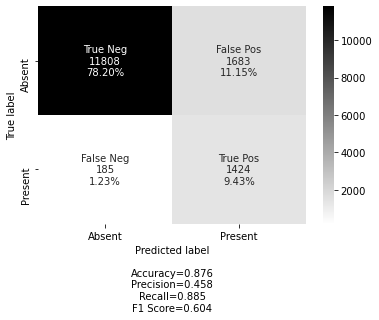

In [61]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

## Save Model
For Chen Kun to do, save the model, load it back, and try to predict on the test case to get the same results

In [62]:
model.save('afl_model_fpga.h5')

## Load Model and Test on OUT OF SAMPLE Data
For Chen Kun to do, load and preprocess the chapman and ningbo data, then use the saved model to predict the conditions and analyze its performance with the confusion table and related metrics

In [40]:
loaded_model = tf.keras.models.load_model('afl_model_fpga.h5')
loaded_model.summary()

Model: "simple-res"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inp (InputLayer)            [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 512, 8)            48        
                                                                 
 re_lu (ReLU)                (None, 512, 8)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 16)           400       
                                                                 
 re_lu_1 (ReLU)              (None, 256, 16)           0         
                                                        

### Test model using unseen datasets

In [46]:
x_test = np.array(test_df['Recording'])
x_test

array(['data/chapman/JS01972.mat', 'data/chapman/JS03803.mat',
       'data/chapman/JS08956.mat', 'data/chapman/JS09490.mat',
       'data/chapman/JS08942.mat', 'data/chapman/JS09484.mat',
       'data/chapman/JS03817.mat', 'data/chapman/JS01966.mat',
       'data/chapman/JS04836.mat', 'data/chapman/JS03181.mat',
       'data/chapman/JS00488.mat', 'data/chapman/JS01796.mat',
       'data/chapman/JS07481.mat', 'data/chapman/JS06947.mat',
       'data/chapman/JS05296.mat', 'data/chapman/JS05282.mat',
       'data/chapman/JS07495.mat', 'data/chapman/JS06953.mat',
       'data/chapman/JS01782.mat', 'data/chapman/JS04822.mat',
       'data/chapman/JS03195.mat', 'data/chapman/JS04611.mat',
       'data/chapman/JS02260.mat', 'data/chapman/JS06006.mat',
       'data/chapman/JS09335.mat', 'data/chapman/JS01769.mat',
       'data/chapman/JS00477.mat', 'data/chapman/JS07318.mat',
       'data/chapman/JS10102.mat', 'data/chapman/JS00311.mat',
       'data/chapman/JS08995.mat', 'data/chapman/JS0676

In [47]:
y_test = np.array(test_df[['Afl']])
y_test.shape

(10247, 1)

In [48]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(get_val)
test_dataset = test_dataset.batch(64, drop_remainder=False)

In [67]:
y_pred = loaded_model.predict(test_dataset)
y_pred

array([[0.22424307],
       [0.08183596],
       [0.10036707],
       ...,
       [0.16391253],
       [0.12145177],
       [0.1208095 ]], dtype=float32)

In [68]:
y_pred.shape

(10247, 1)

In [69]:
np.around(y_pred).astype(np.int)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [70]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [71]:
afl_true = y_test.T[0]
afl_pred = y_pred.T[0]

afl_pred = np.around(afl_pred).astype(np.int)

In [72]:
cf_m = confusion_matrix(afl_true, afl_pred)
cf_m

array([[7176, 2626],
       [  87,  358]])

True Postive Rate: 0.8044943820224719
False Postive Rate: 0.26790450928381965


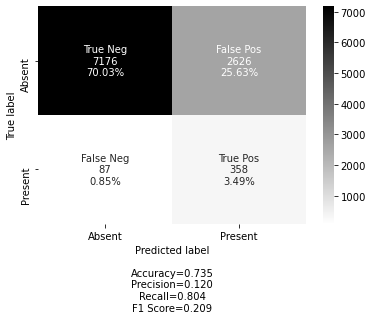

In [73]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

# Get Intermediate Outputs

In [41]:
from tensorflow.keras import backend as K

In [43]:
model = loaded_model

In [44]:
len(model.layers)

13

In [49]:
for batch, (x, y) in enumerate(test_dataset):
    if batch > 0:
        break
print("batch: ", batch)
print("Data shape: ", x.shape, y.shape)

batch:  1
Data shape:  (64, 512, 1) (64, 1)


In [105]:
ecg_input = x[41].numpy()
ecg_input = ecg_input.T

In [62]:
string = ''

In [107]:
string = string + 'Output 0 ==================================== '
string = string + '\n\n'

inputs = x[41].numpy()

for element in inputs:
    string = string + str(round(element[0] * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [241]:
string = string + 'Output 1 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[1].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [242]:
string = string + 'Output 2 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[2].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [243]:
string = string + 'Output 3 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[3].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [244]:
string = string + 'Output 4 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[4].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [245]:
string = string + 'Output 5 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[5].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [246]:
string = string + 'Output 6 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[6].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [247]:
string = string + 'Output 7 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[7].output])
layer_output = get_layer_output(ecg_input)[0][0]

for row in layer_output:
    for element in row:
        string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [248]:
string = string + 'Output 8 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[8].output])
layer_output = get_layer_output(ecg_input)[0][0]

for element in layer_output:
    string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [249]:
string = string + 'Output 9 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[9].output])
layer_output = get_layer_output(ecg_input)[0][0]

for element in layer_output:
    string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [250]:
string = string + 'Output 10 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[10].output])
layer_output = get_layer_output(ecg_input)[0][0]

for element in layer_output:
    string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [251]:
string = string + 'Output 11 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[11].output])
layer_output = get_layer_output(ecg_input)[0][0]

for element in layer_output:
    string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [108]:
string = string + 'Output 12 ==================================== '
string = string + '\n\n'

get_layer_output = K.function([model.layers[0].input], [model.layers[12].output])
layer_output = get_layer_output(ecg_input)[0][0]

for element in layer_output:
    string = string + str(round(element * 256)) + '\t'
    string = string + '\n'

string = string + '\n\n\n\n'

In [109]:
with open('cnn_outputs.txt', 'w') as f:
    f.write(string)

In [106]:
loaded_model.predict([ecg_input])

array([[0.76884127]], dtype=float32)